# KNN IMPLEMENTATION

## This project implements the K-Nearest Neighbors (KNN) algorithm using PyTorch in Google Colab. The solution is designed to solve classification problems, leveraging the flexibility and efficiency of PyTorch. It includes a detailed description of the training process, hyperparameter tuning, and model performance evaluation, along with practical examples applied to common datasets.

------------------------------------------------


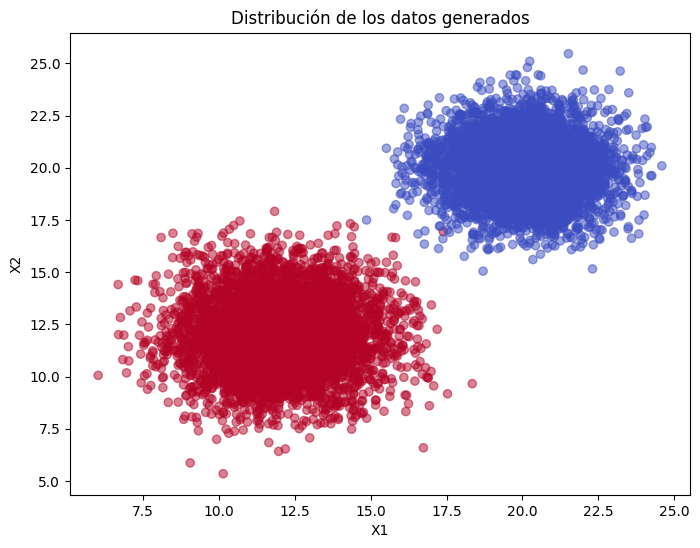

Prueba con k = 7 y distancia Euclideana
Tasa de acierto con norma Euclideana: 0.9995999932289124
Duración con norma Euclideana: 10.362261295318604 segundos
------------------------------------------------
Prueba con k = 7 y distancia de Manhattan
Tasa de acierto con norma de Manhattan: 0.9998000264167786
Duración con norma de Manhattan: 10.51078724861145 segundos
------------------------------------------------
Prueba con k = 7 y distancia de Chebyshev
Tasa de acierto con norma de Chebyshev: 0.9997000098228455
Duración con norma de Chebyshev: 10.452414274215698 segundos
------------------------------------------------

Pruebas con diferentes medias para observar separabilidad:


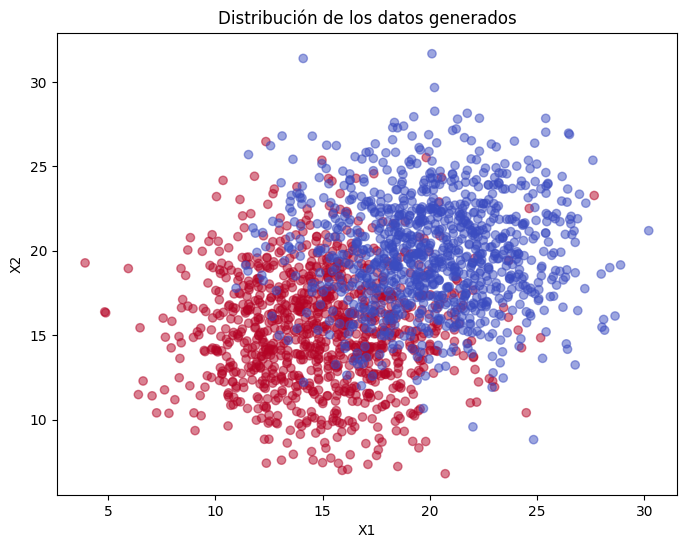

Pruebas con diferentes medias y distancia euclidiana
Tasa de acierto Euclideana con diferentes medias: 0.8774999976158142
Duración con norma Euclideana: 0.3792119026184082 segundos
/n/n/n -----------------------------------------------
Evaluando una observación individual:
La categoría predicha para el punto [[12.5, 14.5]] es: 1.0


In [3]:
from __future__ import print_function
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.distributions import multivariate_normal

""" Crea los datos que se utilizarán para el entrenamiento con dos clases y sus respectivas medias y desviaciones estándar.
    :param numeroMuestraClase: Número de muestras por clase.
    :param media1: Media para la clase 1.
    :param media2: Media para la clase 2.
    :param dv_estandar1: Desviaciones estándar para la clase 1.
    :param dv_estandar2: Desviaciones estándar para la clase 2.
    :return: labels_training, data_training: Etiquetas generadas y muestras de datos.
"""
def crearDatos(numeroMuestraClase=2, media1=[12, 12], media2=[20, 20], dv_estandar1=[3, 3], dv_estandar2=[2, 2]):
    # Clase 1
    clase_media1 = torch.tensor(media1)
    matriz_covarianza_clase1 = torch.diag(torch.tensor(dv_estandar1))
    muestrasClase1 = crearDatosClase1(clase_media1, matriz_covarianza_clase1, numeroMuestraClase)
    # Clase 2
    clase_media2 = torch.tensor(media2)
    matriz_covarianza_clase2 = torch.diag(torch.tensor(dv_estandar2))
    samplesClass2 = crearDatosClase1(clase_media2, matriz_covarianza_clase2, numeroMuestraClase)
    # Combinar ambos clases
    data_training = torch.cat((muestrasClase1, samplesClass2), 0)
    # Crear etiquetas: 1 para clase 1 and 0 para clase 2
    clase1 = torch.ones(numeroMuestraClase, 1)
    clase2 = torch.zeros(numeroMuestraClase, 1)
    labels_training = torch.cat((clase1, clase2), 0)

    return labels_training, data_training



"""Crea datos para una clase utilizando una distribución normal multivariante.
    :param medias: Vector de medias para la clase (centro de la distribución).
    :param matrizCovarianza: Matriz de covarianza para la clase (define la dispersión de los datos).
    :param numeroMuestras: Número de muestras a generar para la clase.
    :return: Muestras generadas a partir de la distribución normal multivariante.
"""
def crearDatosClase1(medias, matrizCovarianza, numeroMuestras):
    multiGaussGenerator = multivariate_normal.MultivariateNormal(medias.float(), matrizCovarianza.float())
    samples = multiGaussGenerator.sample(torch.Size([numeroMuestras]))
    return samples



""" Calcula la distancia entre una observación de prueba y todas las muestras en data_training usando norma Lp.
    :param data_training: Matriz de todas las muestras de entrenamiento (N x d)
    :param test_observation: Observación de prueba (1 x d)
    :param p: Tipo de norma Lp a utilizar
    :return: Vector de distancias (N x 1)
"""
def construir_matriz_distancia(data_training, test_observation, p):
    # Expandimos la observación de prueba para que coincida con el tamaño de data_training
    test_observation_expanded = test_observation.repeat(data_training.size(0), 1)
    # Calculamos las diferencias absolutas entre las muestras y la observación de prueba
    diferencias = torch.abs(data_training - test_observation_expanded)
    if p == 1:
        # Distancia Manhattan (suma de las diferencias absolutas)
        distancias = torch.sum(diferencias, dim=1)
    elif p == 2:
        # Distancia Euclidiana (suma de cuadrados y raíz cuadrada usando PyTorch)
        distancias = torch.sqrt(torch.sum(torch.pow(diferencias, 2), dim=1))
    elif p == float('inf'):
        # Distancia Chebyshev (máxima diferencia absoluta usando torch.max)
        distancias = torch.max(diferencias, dim=1)[0]
    else:
        # Para otros valores de p, calculamos la norma Lp general utilizando torch.pow
        distancias = torch.pow(torch.sum(torch.pow(diferencias, p), dim=1), 1/p)

    return distancias





"""  Esta función evalúa una observación de prueba usando el algoritmo KNN de manera completamente matricial.

    :param data_training: Matriz de datos de entrenamiento (N x d)
    :param labels_training: Vector de etiquetas de entrenamiento (N x 1)
    :param test_observation: Observación de prueba (1 x d)
    :param K: Número de vecinos más cercanos a considerar
    :param p: Tipo de norma Lp a utilizar
    :return: Etiqueta estimada para la observación de prueba
"""
def evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_observation, p , K=7):

    # Calcula la matriz de distancias utilizando la norma Lp
    distancias = construir_matriz_distancia(data_training, test_observation, p)

    # Ordena las distancias en orden ascendente y obtiene los índices correspondientes usando torch.sort
    sorted_distancias, sorted_indices = torch.sort(distancias)

    # Selecciona los K vecinos más cercanos
    k_nearest_indices = sorted_indices[:K]

    # Obtiene las etiquetas correspondientes a los K vecinos más cercanos
    k_nearest_labels = labels_training[k_nearest_indices]

    # Vota por la clase mayoritaria entre los vecinos utilizando torch.mode
    etiqueta_escogida = torch.mode(k_nearest_labels, 0).values.item()

    return etiqueta_escogida




"""
    Evalúa todas las observaciones del conjunto de prueba usando el algoritmo KNN de manera completamente matricial
    utilizando la distancia Euclidiana (p=2) o la distancia de Manhattan (p=1) según el parámetro is_euclidian.

    :param data_training: Matriz de datos de entrenamiento (N x d)
    :param labels_training: Vector de etiquetas de entrenamiento (N x 1)
    :param test_dataset: Matriz de datos de prueba (M x d)
    :param K: Número de vecinos más cercanos a considerar (por defecto 3)
    :param is_euclidian: True para usar la distancia Euclidiana, False para usar la distancia Manhattan
    :return: Vector de etiquetas estimadas para el conjunto de prueba
"""
def evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, test_dataset, K = 3, is_euclidian=True):
    # Determinamos la norma Lp según el valor de is_euclidian
    if is_euclidian is True:
        p = 2  # Euclidiana
    elif is_euclidian is False:
        p = 1  # Manhattan
    else:
        p = float('inf')  # Chebyshev (por ejemplo, si is_euclidian = None)

    # Calculamos la distancia entre cada observación de prueba y todas las muestras de entrenamiento
    distancias = torch.cdist(test_dataset, data_training, p=p)

    # Ordenamos las distancias para cada observación de prueba y obtenemos los índices de los vecinos más cercanos
    sorted_distancias, sorted_indices = torch.sort(distancias, dim=1)

    # Seleccionamos los K vecinos más cercanos para cada observación de prueba
    k_nearest_indices = sorted_indices[:, :K]

    # Obtenemos las etiquetas correspondientes a los K vecinos más cercanos
    k_nearest_labels = labels_training[k_nearest_indices]

    # Votamos por la clase mayoritaria entre los K vecinos para cada observación de prueba
    etiqueta_escogidas, _ = torch.mode(k_nearest_labels, dim=1)

    return etiqueta_escogidas




""" Punto 2.1.c
    Parámetros de entrada:
    :param estimaciones_test: Tensor de las predicciones generadas por el modelo (dimensión N x 1)
    :param test_labels: Tensor con las etiquetas reales de las muestras (dimensión N x 1)
    :return Tasa de aciertos: Un número flotante que representa el porcentaje de predicciones correctas, entre 0 y 1.
"""
# Calcula la tasa de aciertos
def calcular_tasa_aciertos(estimaciones_test, test_labels):

    # Obtiene la cantidad total de muestras en las etiquetas de prueba
    cantidad_muestras_totales = test_labels.shape[0]

    # Calcula cuántas predicciones fueron correctas comparando estimaciones con las etiquetas reales
    estimaciones_totales_correctas = (estimaciones_test == test_labels).sum()

    # Calcula la tasa de aciertos dividiendo el número de predicciones correctas entre el total de muestras
    return (estimaciones_totales_correctas / cantidad_muestras_totales).item()


# Función de graficación de datos
def graficar_datos(data_training, labels_training):
    plt.figure(figsize=(8, 6))
    plt.scatter(data_training[:, 0], data_training[:, 1], c=labels_training.flatten(), cmap='coolwarm', alpha=0.5)
    plt.title("Distribución de los datos generados")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

# Main
def main():

    print("------------------------------------------------")
    (labels_training, data_training) = crearDatos(numeroMuestraClase=5000, media1=[12,12], media2=[20, 20], dv_estandar1=[3, 3], dv_estandar2=[2, 2])
    # Graficación de los datos
    graficar_datos(data_training, labels_training)


    # Punto 2.1
    # Prueba con distancia Euclidiana (p = 2)
    print("Prueba con k = 7 y distancia Euclideana")
    start_time = time.time()
    test_estimations_all = evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, data_training, K=7, is_euclidian=True)
    acierto_euclidiana = calcular_tasa_aciertos(test_estimations_all, labels_training)
    print("Tasa de acierto con norma Euclideana:", acierto_euclidiana)
    elapsed_time = time.time() - start_time
    print("Duración con norma Euclideana:", elapsed_time, "segundos")

    print("------------------------------------------------")

    # Prueba con distancia Manhattan (p = 1)
    print("Prueba con k = 7 y distancia de Manhattan")
    start_time = time.time()
    test_estimations_all_manhattan = evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, data_training, K=7, is_euclidian=False)
    acierto_manhattan = calcular_tasa_aciertos(test_estimations_all_manhattan, labels_training)
    print("Tasa de acierto con norma de Manhattan:", acierto_manhattan)
    elapsed_time = time.time() - start_time
    print("Duración con norma de Manhattan:", elapsed_time, "segundos")

    print("------------------------------------------------")

    # Prueba con distancia Chebyshev (p = float('inf'))
    print("Prueba con k = 7 y distancia de Chebyshev")
    start_time = time.time()
    test_estimations_all_chebyshev = evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, data_training, K=7, is_euclidian=None)
    acierto_chebyshev = calcular_tasa_aciertos(test_estimations_all_chebyshev, labels_training)
    print("Tasa de acierto con norma de Chebyshev:", acierto_chebyshev)
    elapsed_time = time.time() - start_time
    print("Duración con norma de Chebyshev:", elapsed_time, "segundos")




    # Punto
    print("------------------------------------------------")
    # Prueba con diferentes medias para observar la separabilidad de los datos
    print("\nPruebas con diferentes medias para observar separabilidad:")
    (labels_training_diff_means, data_training_diff_means) = crearDatos(numeroMuestraClase=1000, media1=[15, 15], media2=[20,20], dv_estandar1=[11, 11], dv_estandar2=[11, 11])
    # Graficamos los datos con medias diferentes y desviaciones estándar
    graficar_datos(data_training_diff_means, labels_training_diff_means)
    # Pruebas con diferentes medias y desviaciones estándar
    print("Pruebas con diferentes medias y distancia euclidiana")
    start_time = time.time()
    test_estimations_diff_means = evaluate_k_nearest_neighbors_test_dataset(data_training_diff_means, labels_training_diff_means, data_training_diff_means, K=7, is_euclidian=True)
    accuracy_diff_means = calcular_tasa_aciertos(test_estimations_diff_means, labels_training_diff_means)
    print("Tasa de acierto Euclideana con diferentes medias:", accuracy_diff_means)
    elapsed_time = time.time() - start_time
    print("Duración con norma Euclideana:", elapsed_time, "segundos")



    # Evaluación de puntos individuales
    print("/n/n/n -----------------------------------------------")
    print("Evaluando una observación individual:")

    # Observación de un punto con ajuste de dimensiones
    test_observation = torch.tensor([[12.5, 14.5]])

    # Clasifica el punto utilizando KNN con la distancia Euclidiana
    predicted_label = evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_observation, p=2, K=7)

    # Roja = 1, Azul = 0
    print(f"La categoría predicha para el punto {test_observation.tolist()} es: {predicted_label}")

main()